# Load Packages

In [1]:
using Dates,DelimitedFiles, MathProgBase, Ipopt, HDF5

include("jlFiles/printmat.jl")
include("jlFiles/printTable.jl")

println4Ps (generic function with 2 methods)

In [2]:
using Plots
backend = "gr"              #"gr" (default), "pyplot" 

if backend == "pyplot"
    pyplot(size=(600,400))
else    
    gr(size=(480,320))
    default(fmt = :svg)    
end

# Loading Data


from a hdf5 file (a common data format, used by many languages). 

See https://support.hdfgroup.org/products/java/hdfview/
for a program that lets you look at the contents of a hdf5 file. (It is not needed here.)

In [3]:
fh = h5open("Data/Fin1PerfEvalEmp.h5","r")   #open for reading
  (ymd,Rb,IndNames,RFunds,FundNames) = read(fh,"Data/ymd","Data/Rb",
                                               "Data/IndNames","Data/RFunds","Data/FundNames")
close(fh)
dN = Date.(ymd[:,1],ymd[:,2],ymd[:,3])       #2001,12,31 to julia date

println("\nThe funds: ")
for i = 1:length(FundNames)
    println(FundNames[i])
end

println("\nIndices: ")
for i = 1:length(IndNames)
    println(IndNames[i])
end


The funds: 
Putnam Asset Allocation: Growth A
Vanguard Wellington

Indices: 
Equity: US, LargeCap, Value
Equity: US, LargeCap, Growth
Equity: US, MidCap
Equity: US, SmallCap
Equity: Int. (ex US), Developed
Equity: Emerging Markets
Fixed Income: US, Bills
Fixed Income: US, Gov. Bonds
Fixed Income: US, Corp. Bonds
Fixed Income: Non-US, Bonds


# A Function for Style Analysis


Notice:  
(a)  The regression is $Y = a_1 X_1 + ...+ a_K X_K + u$,
               where $a_j >= 0$, $a_j <= 1$ and $a_1+...+a_K = 1$. 
                             
(b) To minimize the sum of squared residuals, we use `quadprog` from MathProgBase, which solves

 $\min 0.5 b'Qb + c'b$ s.t. $Aeq \times x = beq$ and $lb \le x \le ub$
                    
(c) Write the sum of squared residuals of the regression as   

$(Y-Xb)'(Y-Xb) = Y'Y - 2(Y'X)b + b'X'Xb$,

so $Q = 2X'X$ and $c = -2X'Y$. 
Notice that the $Y'Y$ term does not affect the minimization problem.
                              
(d) Here, `X = Rm`, `Y = R`. For simplicity we multiply both $Q$ and $c$ by $1/(2T)$, which does not change
the optimial solution.

In [4]:
function StyleAnalysisPs(Y,X)

    (T,K) = (size(X,1),size(X,2))

    Q   = X'X/T
    ub  = ones(K)                         #w <= 1
    lb  = zeros(K)                        #w >= 0
    Aeq = ones(1,K)                       #1'w = 1
    beq = 1.0

    b_ls = X\Y                          #LS estimate of weights, no restrictions
    c    = -X'Y/T
    Sol  = quadprog(c,Q,Aeq,'=',beq,lb,ub,IpoptSolver(print_level=0))
    if Sol.status == :Optimal
      b = Sol.sol
    else
      b = NaN
    end

  return b,b_ls

end

StyleAnalysisPs (generic function with 1 method)

The next cell makes a "style analysis regression" based on the entire sample. The dependent variable is the first mutual fund in RFunds (see data loading) and all indices (again, see data loading) are used as regressors.

In [5]:
(b,b_ls) = StyleAnalysisPs(RFunds[:,1],Rb)

println("OLS and style analysis coeffs")
colNames = ["OLS" "Restricted LS"]
xut = [b_ls b;sum([b_ls b],dims=1)]
printTable(xut,colNames,[IndNames;"Sum"],width=15)

vvSort = sortperm(b,rev=true)    #indices so that b[vvSort] is sorted in descending order
printlnPs("\nthe 3 most important benchmarks are: ")
printmat(IndNames[vvSort[1:3]])


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

OLS and style analysis coeffs
                                           OLS  Restricted LS
Equity: US, LargeCap, Value              0.129          0.130
Equity: US, LargeCap, Growth             0.098          0.098
Equity: US, MidCap                       0.079          0.078
Equity: US, SmallCap                     0.061          0.062
Equity: Int. (ex US), Developed          0.413          0.413
Equity: Emerging Markets                 0.047          0.049
Fixed Income: US, Bills                  0.091          0.063
Fixed Income: US, Gov. Bonds            -0.065          0.004
Fixed Income: US, Corp. 

# Redo the Style Analysis on a Moving Data Window 

of size `WinSize` (see below). Then plot to see how the coefficients change over time. 

In [6]:
(T,K)   = size(Rb)
WinSize = 104

b = fill(NaN,(T,K))
for t = (WinSize+1):T
    local vv
    vv     = (t-WinSize):t
    b[t,:] = StyleAnalysisPs(RFunds[vv,1],Rb[vv,:])[1]
end

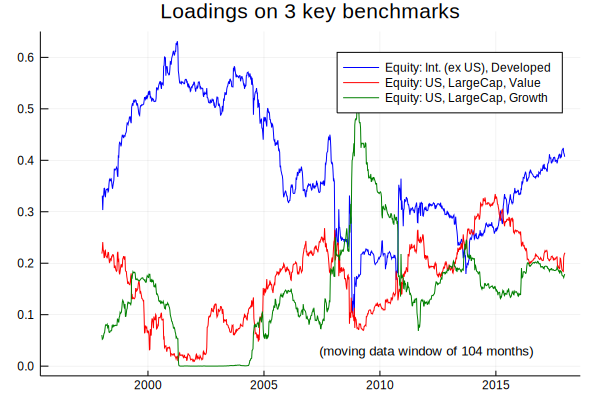

In [7]:
xTicksLoc = Dates.value.([Date(2000);Date(2005);Date(2010);Date(2015)])
xTicksLab = ["2000";"2005";"2010";"2015"]              

p1 = plot(dN,b[:,vvSort[1:3]],color=[:blue :red :green],label=IndNames[vvSort[1:3]],
          xticks=(xTicksLoc,xTicksLab),size=(600,400))
title!("Loadings on 3 key benchmarks")
annotate!(Dates.value(Date(2012)),0.03,text("(moving data window of $WinSize months)",9))